## DISTRACTED DRIVER DETECTION- IMAGE CLASSIFICATION


## Kaggle
### Install Kaggle

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

### Upload "Kaggle.json"

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hamnamoiz","key":"fe51f117ffdef387e35130c79bbdc34d"}'}

In [0]:
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 

kaggle.json


### Import dataset from kaggle into google colab

In [0]:
!kaggle competitions download -c state-farm-distracted-driver-detection

  0% 0.00/193k [00:00<?, ?B/s]
100% 193k/193k [00:00<00:00, 72.6MB/s]
100% 3.99G/4.00G [01:13<00:00, 43.1MB/s]
100% 4.00G/4.00G [01:13<00:00, 58.2MB/s]
  0% 0.00/92.9k [00:00<?, ?B/s]
100% 92.9k/92.9k [00:00<00:00, 74.4MB/s]


### Unzip files

In [0]:
!unzip -q imgs.zip -d ./imgs

## Data Manipulation
### Load and pre-process data

In [0]:
import cv2
import glob
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import os
import numpy as np
import keras
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Input
from keras import layers
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, \
                                       ZeroPadding2D,Conv2D
from keras import backend as K
from keras.optimizers import SGD, RMSprop
from keras.layers.normalization import BatchNormalization

np.random.seed(2016)
use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 3

# color_type = 1 - gray
# color_type = 3 - RGB


def get_image(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # resize - reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized

def load_data(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []

    print('Loading data:')
    for j in range(10):
        print('Read images from folder c{}'.format(j))
        path = os.path.join('./imgs', 'train',
                            'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            img = get_image(fl, img_rows, img_cols, color_type)
            X_train.append(img)
            y_train.append(j)
    return X_train, y_train
img_rows = 224
img_cols = 224

images , labels = load_data(img_rows, img_cols, color_type_global)
images = np.array(images)
labels = np.array(labels)
print(images.shape)
print(labels.shape)


Loading data:
Read images from folder c0
Read images from folder c1
Read images from folder c2
Read images from folder c3
Read images from folder c4
Read images from folder c5
Read images from folder c6
Read images from folder c7
Read images from folder c8
Read images from folder c9
(22424, 224, 224, 3)
(22424,)


### Create train, validation and test sets
here we divide the dataset into train, test and validation sets, the ditribution is as follows:

Training Data => 80% of total dataset 

Testing Data => 20% of total dataset

Validation Data => 20% of training dataset

In [0]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size= 0.2, random_state = 42)
images_train = np.asarray(images_train)
images_test = np.asarray(images_test)
labels_train = np.asarray(labels_train)
labels_test_1 = np.asarray(labels_test)
print(images_train.shape)
print(images_test.shape)

images_train, images_val, labels_train, labels_val = train_test_split(images_train, labels_train, test_size= 0.2, random_state = 42)
images_train = np.asarray(images_train)
images_val = np.asarray(images_val)
labels_train = np.asarray(labels_train)
labels_val = np.asarray(labels_val)
print(images_train.shape)
print(images_val.shape)

#if you have 10 classes, the target for each sample should be a 10-dimensional vector
#that is all-zeros except for a 1 at the index corresponding to the class of the sample
num_classes = 10
labels_train = keras.utils.to_categorical(labels_train, num_classes)
labels_val = keras.utils.to_categorical(labels_val, num_classes)
labels_test = keras.utils.to_categorical(labels_test_1, num_classes)


(17939, 224, 224, 3)
(4485, 224, 224, 3)
(14351, 224, 224, 3)
(3588, 224, 224, 3)


## Model
### Build a Model
Here we create our training model, namely, "**simplified VGG net**" while below mentioned specifications

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense


batch_size = 32
epochs = 10

input_shape = (img_rows, img_cols, color_type_global)

model = Sequential()

# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
  # (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

  # (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

  # first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

  # *sigmoid* activation for multi-label classification
model.add(Dense(num_classes))
model.add(Activation("sigmoid"))

### Compile the model
The model is compiled using the below mentioned specifications:

In [0]:
model.compile(optimizer=SGD(lr=0.001, momentum=0.00, decay=0.00), loss='categorical_crossentropy', metrics=['accuracy'])

### Fit the model

In [0]:
history = model.fit(images_train, labels_train, batch_size=batch_size,
                      epochs=epochs, verbose=1,
                      validation_data=(images_val, labels_val))
model.summary()

Train on 14351 samples, validate on 3588 samples
Epoch 1/10
14351/14351 [==============================] - 47s 3ms/step - loss: 2.1321 - acc: 0.2656 - val_loss: 1.7284 - val_acc: 0.5424
Epoch 2/10
14351/14351 [==============================] - 45s 3ms/step - loss: 1.7304 - acc: 0.4591 - val_loss: 1.3487 - val_acc: 0.6720
Epoch 3/10
14351/14351 [==============================] - 45s 3ms/step - loss: 1.4693 - acc: 0.5505 - val_loss: 1.1068 - val_acc: 0.6597
Epoch 4/10
14351/14351 [==============================] - 45s 3ms/step - loss: 1.2354 - acc: 0.6115 - val_loss: 0.8798 - val_acc: 0.7486
Epoch 5/10
14351/14351 [==============================] - 45s 3ms/step - loss: 1.0691 - acc: 0.6680 - val_loss: 0.8145 - val_acc: 0.7631
Epoch 6/10
14351/14351 [==============================] - 45s 3ms/step - loss: 0.9474 - acc: 0.6891 - val_loss: 0.7426 - val_acc: 0.7754
Epoch 7/10
14351/14351 [==============================] - 45s 3ms/step - loss: 0.8528 - acc: 0.7168 - val_loss: 0.7289 - val_acc:

### Plot results - training vs validation

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


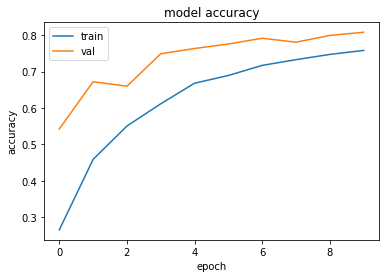

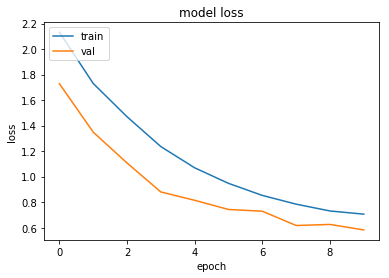

In [0]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss`+a
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

from keras.utils import plot_model
plot_model(model, to_file='model.png')

### Evaluate the model - On test set

In [0]:
score = model.evaluate(images_test, labels_test, verbose=0)
label_score = model.predict(images_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6091796477635701
Test accuracy: 0.7946488294580176


### Visualize performance on test images

In [0]:
from keras.preprocessing import image

category_dict = {"c0": "safe driving",
                 "c1": "texting - right",
                 "c2": "talking on the phone - right",
                 "c3": "texting - left",
                 "c4": "talking on the phone - left",
                 "c5": "operating the radio",
                 "c6": "drinking",
                 "c7": "reaching behind",
                 "c8": "hair and makeup",
                 "c9": "talking to passenger"}

count = 0
for img, label in zip(images_test, labels_test_1):
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  plt.imshow(img_tensor[0])
  plt.show()
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  pred_class = model.predict_classes(images, batch_size=10)
  print("Predicted class is: ",category_dict["c"+str(pred_class[0])])
  print("Original class is: ", category_dict["c"+str(label)])
  count +=1
  if count == 50:
    break

## ROC curve

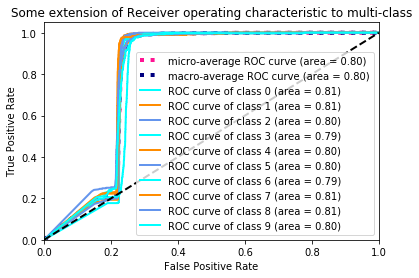

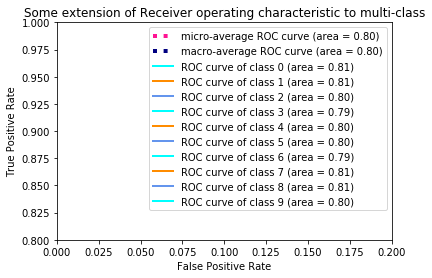

In [0]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(labels_test[:, i], label_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(labels_test.ravel(), label_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="best")
plt.show()